In [35]:
# Imports
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb  # brew install lightgbm (on MacOS)
import pickle

# Load data

In [2]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

In [3]:
# One-hot-encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [21]:
## Create a parameter grid for gridsearch

# Create the random grid
random_grid = {
    'objective': ['binary'],
    'num_leaves': [5, 10, 20, 50], 
    'min_data_in_leaf': [0, 10, 20, 40],
    'max_depth': [5, 10, 15],
    'max_bin': [5, 10, 25, 50],
    'learning_rate':[0.001, 0.01, 0.1],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'n_estimators': [1000, 5000, 10000],
    'bootstrap': [True, False]
        }
               
print(random_grid)

{'objective': ['binary'], 'num_leaves': [5, 10, 20, 50], 'min_data_in_leaf': [0, 10, 20, 40], 'max_depth': [5, 10, 15], 'max_bin': [5, 10, 25, 50], 'learning_rate': [0.001, 0.01, 0.1], 'dart': [True, False], 'reg_alpha': [0, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 0.01, 0.1, 1, 10, 100], 'n_estimators': [1000, 5000, 10000], 'bootstrap': [True, False]}


In [23]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = lgb.LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
gb_gridsearch = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_jobs=2,
                                   scoring="f1_weighted", n_iter=2000, cv=5, verbose=6, random_state=42)
# Fit the random searfch model
gb_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
gb_gridsearch.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.6min
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 29.5min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 51.4min
[Parallel(n_jobs=2)]: Done 309 tasks      | elapsed: 73.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 110.4min
[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 162.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 207.1min
[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed: 282.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 347.5min
[Parallel(n_jobs

{'reg_lambda': 100,
 'reg_alpha': 0.1,
 'objective': 'binary',
 'num_leaves': 10,
 'n_estimators': 10000,
 'min_data_in_leaf': 20,
 'max_depth': 5,
 'max_bin': 50,
 'learning_rate': 0.01,
 'dart': False,
 'bootstrap': False}

In [26]:
## Evaluate improvment between the base model and the fine-tuned model

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_model = gb_gridsearch.best_estimator_
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.783, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .................................... , score=0.806, total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] .................................... , score=0.778, total=   2.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s


[CV] .................................... , score=0.786, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.9s remaining:    0.0s


[CV] .................................... , score=0.776, total=   3.0s
0.7859250689261568 0.010824381329230333
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.816, total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] .................................... , score=0.829, total=   8.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s


[CV] .................................... , score=0.818, total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.5s remaining:    0.0s


[CV] .................................... , score=0.819, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.6s remaining:    0.0s


[CV] .................................... , score=0.805, total=  11.5s
0.8173340769377951 0.007585348588558676
Improvement of 4.00%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.2s finished


# Train on whole dataset using optimised set of parameters

In [29]:
final_model = lgb.LGBMClassifier(**gb_gridsearch.best_params_, random_state=42)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, dart=False, importance_type='split',
               learning_rate=0.01, max_bin=50, max_depth=5,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=100, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Predict on test and save

In [30]:
# issue: one country 'native-country_ Holand-Netherlands' in test but not in train
X_test = X_test.drop('native-country_ Holand-Netherlands', axis=1)

,prediction
id,
1,0
2,0
3,0
4,0
5,0


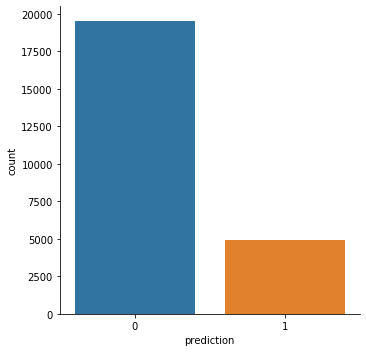

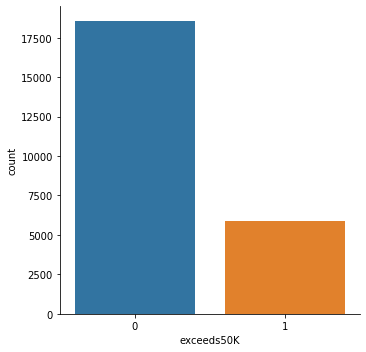

In [33]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index += 1
df.index.name = 'id'
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)
df.head()

In [36]:
# experience name
experience = 'LightGBM_simpleonehotencodingonly'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))